**Table of contents**<a id='toc0_'></a>    
- [Logs for the methylation data app](#toc1_)    
  - [Introduction](#toc1_1_)    
    - [21-11-2024](#toc1_1_1_)    
  - [Loading in the data](#toc1_2_)    
    - [21-11-2024](#toc1_2_1_)    
    - [22-11-2024](#toc1_2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Logs for the methylation data app](#toc0_)

## <a id='toc1_1_'></a>[Introduction](#toc0_)
### <a id='toc1_1_1_'></a>[21-11-2024](#toc0_)

This logbook will describe the process of creating visualisations, ideas. These visualisations and ideas will be used to create an application for research students.
This application will take DNA methylation data as input. This app will make it easier for the students to look into their generated data, and it will help them with understanding their data.


## <a id='toc1_2_'></a>[Loading in the data](#toc0_)
### <a id='toc1_2_1_'></a>[21-11-2024](#toc0_)

I would like to combine the data from all the files into one single file, with the id in the column of the df.
This way i could compare different conditions to eachother.

The first code-block is to load in the used libraries.

In [69]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import re

In [ ]:
barcodes_names: pl.dataframe = pl.read_csv("/home/redman/jaar2/data/Methylatie/barcodes.csv")

barcodes_names = barcodes_names.with_columns(controle_n = pl.int_range(pl.len()).over(" description")+1)
barcodes_names = barcodes_names.with_columns(group_and_n = pl.concat_str([pl.col(' description'), pl.col("controle_n")]))

barcodes_names = barcodes_names.with_columns(pl.col(pl.Utf8).str.strip_chars()).drop("controle_n")

print(barcodes_names)



shape: (5, 3)
┌─────────┬─────────────────────┬──────────────────────┐
│ barcode ┆  description        ┆ group_and_n          │
│ ---     ┆ ---                 ┆ ---                  │
│ i64     ┆ str                 ┆ str                  │
╞═════════╪═════════════════════╪══════════════════════╡
│ 11      ┆ Jurkat_DMSO_control ┆ Jurkat_DMSO_control1 │
│ 12      ┆ Jurkat_betuline     ┆ Jurkat_betuline1     │
│ 13      ┆ Healthy_control     ┆ Healthy_control1     │
│ 14      ┆ Jurkat_betuline     ┆ Jurkat_betuline2     │
│ 15      ┆ Jurkat_DMSO_control ┆ Jurkat_DMSO_control2 │
└─────────┴─────────────────────┴──────────────────────┘


This generates a data frame that contains the barcode and also the description of the barcode
The column called group_and_n contains the description with a control group number

This is needed to label the different groups in the df that will contain all of the data

Which will be loaded in the code below this block

In [ ]:
path: str = "/home/redman/jaar2/data/Methylatie/analysis"
def load_files(path: str) -> pl.dataframe:
    resulting_df: pd.DataFrame = pl.DataFrame(
        {"chr":[],
         "start":[],
         "end":[],
         "frac":[],
         "valid":[],
         "group_name":[]}
    )
    files: list[str] = os.listdir(path)

    for file in files:
        if os.path.isfile(f"{path}/{file}") and file.endswith("methylatie_ALL.csv"):
            temp_df: pd.DataFrame = pd.read_csv(f"{path}/{file}", sep="\t")
            temp_df: pl.DataFrame = pl.from_pandas(temp_df)
            barcode_num: list[int] = re.findall(r"\d+", file)

            name_group: str = barcodes_names.filter(pl.col("barcode").cast(pl.String) == barcode_num[0]).select("group_and_n")
            temp_df: pl.DataFrame = temp_df.with_columns(pl.lit(name_group).alias("group_name"))
            resulting_df = pl.concat([temp_df, resulting_df])
    
    return resulting_df
    
df: pl.DataFrame = load_files(path=path)

All of the csv files are now loaded into 1 polars dataframe

In [89]:

print(df.head())


shape: (5, 6)
┌──────┬───────┬───────┬──────┬───────┬──────────────────┐
│ chr  ┆ start ┆ end   ┆ frac ┆ valid ┆ group_name       │
│ ---  ┆ ---   ┆ ---   ┆ ---  ┆ ---   ┆ ---              │
│ str  ┆ i64   ┆ i64   ┆ f64  ┆ i64   ┆ str              │
╞══════╪═══════╪═══════╪══════╪═══════╪══════════════════╡
│ chr1 ┆ 61624 ┆ 61625 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline1 │
│ chr1 ┆ 61802 ┆ 61803 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline1 │
│ chr1 ┆ 61900 ┆ 61901 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline1 │
│ chr1 ┆ 61921 ┆ 61922 ┆ 1.0  ┆ 1     ┆ Jurkat_betuline1 │
│ chr1 ┆ 61929 ┆ 61930 ┆ 1.0  ┆ 1     ┆ Jurkat_betuline1 │
└──────┴───────┴───────┴──────┴───────┴──────────────────┘


### <a id='toc1_2_2_'></a>[22-11-2024](#toc0_)
I now have a data frame with the methylation data with a column called group_name that holds the name of the group of which the data comes from

In [77]:
test: pl.DataFrame = df.filter(
    pl.col("group_name").is_in(['Healthy_control1', 'Jurkat_betuline1', 'Jurkat_betuline2'])
)
test: pl.DataFrame = df.filter((pl.col("start") >= 60778131) & 
                   (pl.col("end") <= 60778731) & 
                   (pl.col("chr") == "chr10"))
print(test)

shape: (83, 6)
┌───────┬──────────┬──────────┬──────┬───────┬──────────────────┐
│ chr   ┆ start    ┆ end      ┆ frac ┆ valid ┆ group_name       │
│ ---   ┆ ---      ┆ ---      ┆ ---  ┆ ---   ┆ ---              │
│ str   ┆ i64      ┆ i64      ┆ f64  ┆ i64   ┆ str              │
╞═══════╪══════════╪══════════╪══════╪═══════╪══════════════════╡
│ chr10 ┆ 60778212 ┆ 60778213 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ chr10 ┆ 60778217 ┆ 60778218 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ chr10 ┆ 60778237 ┆ 60778238 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ chr10 ┆ 60778258 ┆ 60778259 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ chr10 ┆ 60778283 ┆ 60778284 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ …     ┆ …        ┆ …        ┆ …    ┆ …     ┆ …                │
│ chr10 ┆ 60778682 ┆ 60778683 ┆ 0.0  ┆ 3     ┆ Healthy_control1 │
│ chr10 ┆ 60778689 ┆ 60778690 ┆ 0.0  ┆ 3     ┆ Healthy_control1 │
│ chr10 ┆ 60778700 ┆ 60778701 ┆ 0.0  ┆ 3     ┆ Healthy_control1 │
│ chr10 ┆ 60778707 ┆ 60778708 ┆ 0.0  ┆ 3     ┆ Healthy_contro

In [87]:
all_groups = pl.DataFrame({"group_name": df["group_name"].unique()})

test_agg: pl.DataFrame = (
    test
    .select(["group_name", "frac"])
    .group_by("group_name")
    .agg([pl.len().alias("n methylations")])
    .join(all_groups, on="group_name", how="full")
    .with_columns(pl.col("group_name").fill_null(pl.col("group_name_right")))
    .drop("group_name_right") 
    .fill_null(0)
)
print(test_agg)


shape: (5, 2)
┌──────────────────────┬────────────────┐
│ group_name           ┆ n methylations │
│ ---                  ┆ ---            │
│ str                  ┆ u32            │
╞══════════════════════╪════════════════╡
│ Jurkat_DMSO_control1 ┆ 0              │
│ Jurkat_betuline1     ┆ 0              │
│ Jurkat_DMSO_control2 ┆ 0              │
│ Jurkat_betuline2     ┆ 39             │
│ Healthy_control1     ┆ 44             │
└──────────────────────┴────────────────┘


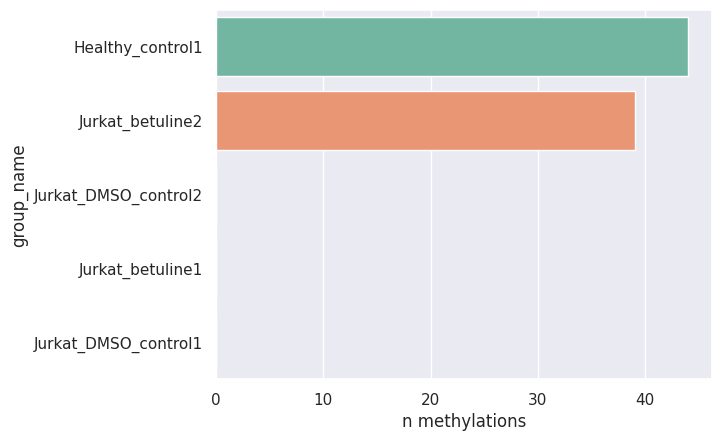

In [88]:
sns.set_theme()

sns.barplot(data = test_agg.reverse(),
            y = "group_name", x = "n methylations",
            hue="group_name", palette="Set2")
plt.show()